[EDA]
a little bit of EDA
how to cross_validate correctly
how to preprocess the data for various classifiers
how to tune the most important hyperparameters of some models
how an ensemble performs better than any single model

In [113]:
<Reading the data> 
    Column Name, Feature Descriptiopn, Feature 의미 해석 정리
    ref: https://www.notion.so/jennykimkr/3-ML-by-10-20-1e4dfc720027487285c522512783035b?pvs=4#7dc3b3e2160e4f0a81438a3d1fc3c4c1

SyntaxError: invalid decimal literal (957879183.py, line 3)

In [114]:
%pip install sklearn 
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

np.set_printoptions(linewidth=195, edgeitems=5)

  Using cached sklearn-0.0.post10.tar.gz (3.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

<데이터 불러오기>

In [140]:
data_path = '../data/'

train_df = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')
original_df = pd.read_csv(data_path+'jm1.csv')

<데이터 이해하기>

In [141]:
train_df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [142]:
train_df.columns

# 결과해석: target column(defects), features(21개의 다른 컬럼) 

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [143]:
train_df.info()

# 결과해석: 총 22개의 columns 중 feature 중 19개가 numeric, 3개가 categorical -> 모든 features는 numerical하다??

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  un

In [147]:
from IPython.core.display_functions import display
with pd.option_context("display.min_rows", 7):
    display(train_df)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


In [148]:
# 데이터의 형태 확인
print(train_df.shape)

# 결과해석: 10000rows 이상, 21개의 feature이므로 풍부한 데이터 -> 오버피팅 걱정할 필요 없음


(101763, 22)


In [149]:
print(train_df.isnull().sum())

# 결과해석: 결측치 없음 (no missing values)

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64


In [150]:
# 컬럼별 유니크한 값의 개수 확인

print(train_df.nunique())


loc                   378
v(g)                  106
ev(g)                  71
iv(g)                  84
n                     836
v                    4515
l                      55
d                    3360
i                    5171
e                    8729
b                     315
t                    8608
lOCode                298
lOComment              91
lOBlank                94
locCodeAndComment      29
uniq_Op                70
uniq_Opnd             176
total_Op              623
total_Opnd            485
branchCount           144
defects                 2
dtype: int64


In [151]:
original_df.columns

# original과 합성 데이터에는 중요한 차이가 있다. -> original 데이터는 포함하지 않는다.

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [152]:
from IPython.core.display_functions import display
with pd.option_context("display.min_rows", 7):
    display(original_df)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1,1,1,1,1,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17,36,112,86,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10882,42.0,4.0,1.0,2.0,103.0,519.57,0.04,26.40,19.68,13716.72,...,29,1,10,0,18,15,59,44,7,False
10883,10.0,1.0,1.0,1.0,36.0,147.15,0.12,8.44,17.44,1241.57,...,6,0,2,0,9,8,21,15,1,False
10884,19.0,3.0,1.0,1.0,58.0,272.63,0.09,11.57,23.56,3154.67,...,13,0,2,1,12,14,31,27,5,False


<original과 합성 데이터의 차이>

- train과 test 데이터는 original 데이터 셋에 기반한 합성데이터로 구성된다 (분포는 같이 않다.)
- original 데이터는 9개의 파생데이터가 있다.

P = volume = V = N * log2(mu) (the number of mental comparisons needed to write a program of length N)
V = volume on minimal implementation = (2 + mu2')log2(2 + mu2')
L = program length = V*/N
D = difficulty = 1/L
L' = 1/D
I = intelligence = L'*V'
E = effort to write program = V/L
T = time to write program = E/18 seconds

- origin 데이터가 합성데이터에 완전히 반영되지는 않음(아래 차트 확인)
- 최종 defects의 비율도 다름

# 결론: 훈련 모델에 original 데이터를 사용하지 않는 것을 추첨함

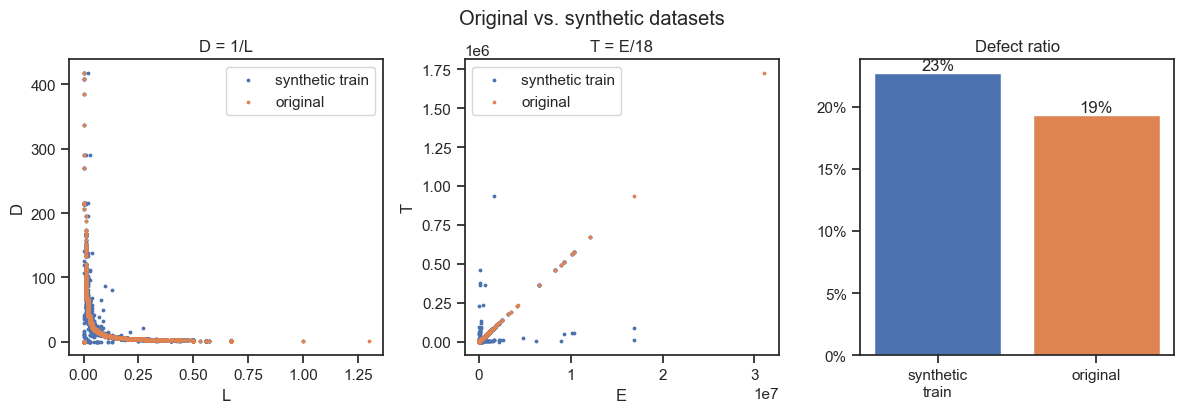

In [125]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(train_df.l, train_df.d, s=3, label='synthetic train')
ax1.scatter(original_df.l, original_df.d, s=3, label='original')
ax1.set_xlabel('L')
ax1.set_ylabel('D')
ax1.set_title('D = 1/L')
ax1.legend()
ax2.scatter(train_df.e, train_df.t, s=3, label='synthetic train')
ax2.scatter(original_df.e, original_df.t, s=3, label='original')
ax2.set_xlabel('E')
ax2.set_ylabel('T')
ax2.set_title('T = E/18')
ax2.legend()
bars1 = ax3.bar([0], [train_df.defects.mean()*100])
bars2 = ax3.bar([1], [original_df.defects.mean()*100])
ax3.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax3.bar_label(bars1, fmt='{:.0f}%')
ax3.bar_label(bars2, fmt='{:.0f}%')
ax3.set_xticks([0, 1], ['synthetic\ntrain', 'original'])
ax3.set_title('Defect ratio')
plt.tight_layout()
plt.suptitle('Original vs. synthetic datasets', y=1.03)
plt.show()

In [153]:
submission_df.head()

,defects
id,
101763,0.5
101764,0.5
101765,0.5
101766,0.5
101767,0.5


<데이터 요약>

In [154]:
def resume_table(df):
    # df = df.drop(columns=target_name)
    summary_df = df.dtypes
    df = df * 1 # defects를 int형으로 바꾸기
    summary_df = summary_df.reset_index()
    summary_df.columns = ['Column', 'Dtypes']
    summary_df['결측치'] = df.isnull().sum().values
    summary_df['유니크개수'] = df.nunique().values
    summary_df['평균'] = df.describe().loc['mean'].values
    summary_df['min'] = df.describe().loc['min'].values
    summary_df['median'] = df.describe().loc['50%'].values
    summary_df['max'] = df.describe().loc['max'].values
    return summary_df.set_index('Column')

resume_table(train_df)

,Dtypes,결측치,유니크개수,평균,min,median,max
Column,,,,,,,
loc,float64,0,378,37.347160,1.0,22.00,3442.00
v(g),float64,0,106,5.492684,1.0,3.00,404.00
ev(g),float64,0,71,2.845022,1.0,1.00,165.00
iv(g),float64,0,84,3.498826,1.0,2.00,402.00
n,float64,0,836,96.655995,0.0,51.00,8441.00
v,float64,0,4515,538.280956,0.0,232.79,80843.08
l,float64,0,55,0.111634,0.0,0.09,1.00
d,float64,0,3360,13.681881,0.0,9.82,418.20
i,float64,0,5171,27.573007,0.0,23.36,569.78


<EDA: 타겟 분포 확인>

- 기술통계량
- log-transformation: 21개의 feature 모두 양수이고 분포는 right-skewed -> exponential distribution(지수분포)와 비슷 -> log transformation이 필요
- 상관관계 (feature selection 고려)
- 박스 플롯 (이상치 제거)
- cross-validation: 어떤 데이터 변환 또는 전처리가 필요한지, 특정 데이터 셋에서 발생할 수 있는 문제점이 무엇인지 예측
  (단, 데이터 불균형: EDA를 통해 클래스 불균형이 발견되면, Cross Validation을 수행할 때 stratified sampling 방법을 사용하여 각 fold에서의 클래스 분포를 원래 데이터셋의 클래스 분포와 유사하게 유지할 수 있음)


In [155]:
# 기술통계량 확인
train_df.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,2.085359e+04,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,1.905714e+05,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,5.647300e+02,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,2.256230e+03,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,1.019324e+04,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


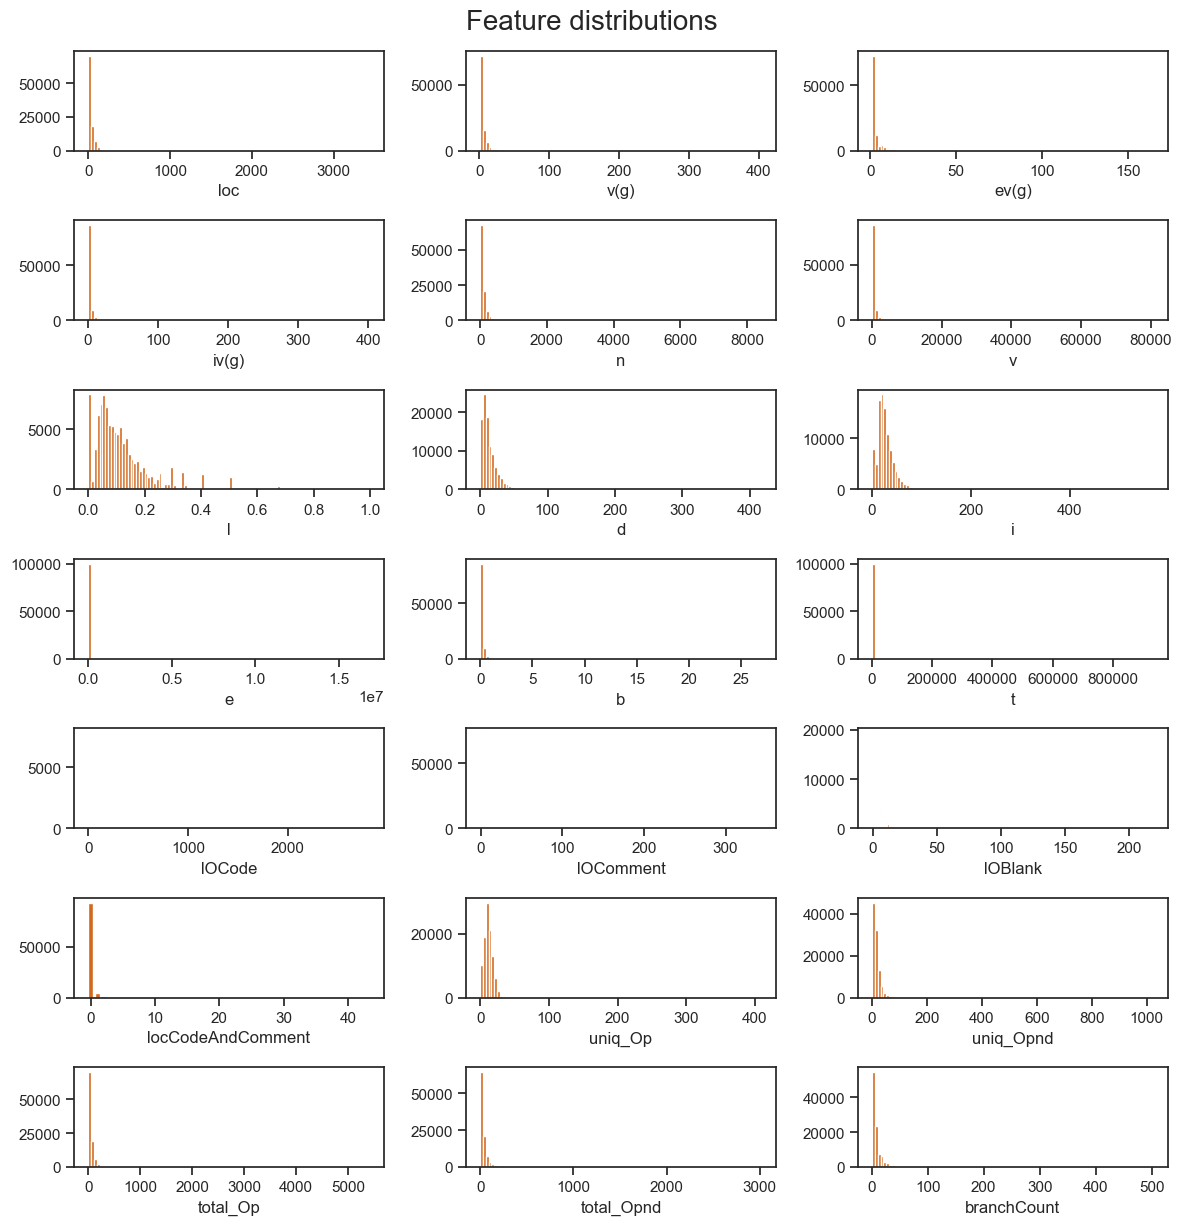

In [156]:
# 데이터의 분포 확인

_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    if train_df[col].dtype == float:
        ax.hist(train_df[col], bins=100, color='chocolate')
    else: #int
        vc = train_df[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

# 결과해석: 21개의 feature 모두 양수이고 분포는 right-skewed되어 있음 -> log 변환 필요

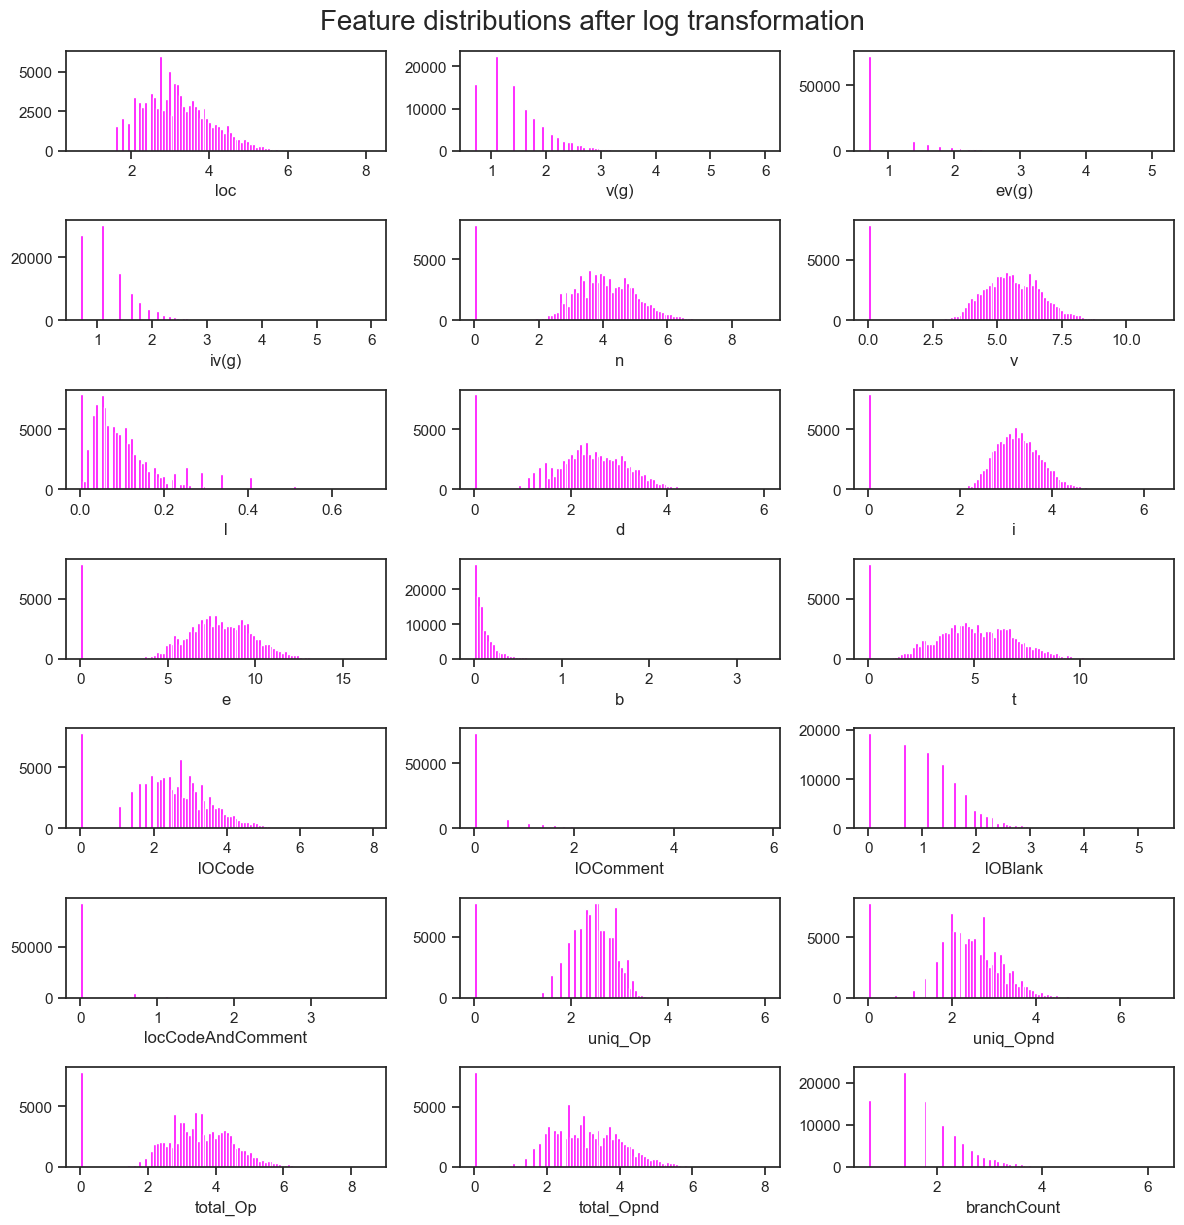

In [157]:
# log transformation(로그 함수 적용)을 통해 데이터의 분포 확인 (히스토그램)
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    ax.hist(np.log1p(train_df[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

# 결과해석: log transformation을 통해 데이터의 분포가 정규분포에 가까워짐 -> 모델 성능 향상에 도움이 될 것으로 예상

In [158]:
# 데이터의 상관관계 확인

corr = train_df.corr().round(2)
corr.style.background_gradient(cmap='coolwarm').format("{:.2f}")

# 결과해석: 상관관계가 높은 feature들이 존재 -> feature selection 필요
# 추후 고려할 방법: 상관관계가 높은 feature들 중 하나만 선택하거나, PCA를 통해 차원 축소를 진행할 수 있음


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
loc,1.00,0.76,0.54,0.70,0.76,0.76,-0.39,0.60,0.49,0.50,0.74,0.51,0.80,0.53,0.67,0.25,0.37,0.64,0.76,0.76,0.76,0.34
v(g),0.76,1.00,0.73,0.79,0.63,0.62,-0.39,0.57,0.30,0.43,0.61,0.47,0.64,0.38,0.46,0.21,0.39,0.53,0.64,0.61,0.97,0.30
ev(g),0.54,0.73,1.00,0.55,0.39,0.37,-0.33,0.36,0.16,0.28,0.36,0.28,0.38,0.29,0.28,0.16,0.20,0.28,0.39,0.37,0.77,0.26
iv(g),0.70,0.79,0.55,1.00,0.59,0.59,-0.29,0.49,0.32,0.39,0.56,0.41,0.64,0.34,0.43,0.18,0.38,0.55,0.59,0.57,0.75,0.25
n,0.76,0.63,0.39,0.59,1.00,0.93,-0.30,0.81,0.73,0.57,0.92,0.60,0.91,0.57,0.78,0.26,0.62,0.82,0.96,0.95,0.63,0.26
v,0.76,0.62,0.37,0.59,0.93,1.00,-0.25,0.75,0.67,0.58,0.94,0.59,0.90,0.53,0.74,0.24,0.54,0.80,0.94,0.94,0.61,0.23
l,-0.39,-0.39,-0.33,-0.29,-0.30,-0.25,1.00,-0.43,-0.16,-0.09,-0.25,-0.10,-0.29,-0.19,-0.29,-0.13,-0.40,-0.28,-0.29,-0.29,-0.42,-0.25
d,0.60,0.57,0.36,0.49,0.81,0.75,-0.43,1.00,0.52,0.47,0.76,0.49,0.78,0.49,0.68,0.27,0.78,0.69,0.81,0.78,0.58,0.24
i,0.49,0.30,0.16,0.32,0.73,0.67,-0.16,0.52,1.00,0.29,0.68,0.30,0.68,0.44,0.65,0.21,0.53,0.80,0.70,0.74,0.31,0.21
e,0.50,0.43,0.28,0.39,0.57,0.58,-0.09,0.47,0.29,1.00,0.61,0.80,0.58,0.33,0.44,0.12,0.28,0.41,0.58,0.57,0.43,0.10


In [159]:
# 높은 상관관계만 확인

corr = train_df.corr().round(2)
corr_abs = corr.abs().stack().sort_values(ascending=False)
corr_abs[corr_abs != 1][:10]


branchCount  v(g)           0.97
v(g)         branchCount    0.97
total_Op     total_Opnd     0.96
total_Opnd   total_Op       0.96
total_Op     n              0.96
n            total_Op       0.96
total_Opnd   n              0.95
n            total_Opnd     0.95
b            v              0.94
total_Opnd   v              0.94
dtype: float64

In [106]:
# (추후 적용 고려) 상관관계가 높은 feature들 중 하나(상관관계가 가장 높은 것 기준)만 선택해도 모델 성능 향상에 도움이 될 것으로 예상 

# corr = train_df.corr().round(2)
# corr_abs = corr.abs().stack().sort_values(ascending=False)
# highest_corr = corr_abs[corr_abs != 1].index[0]
# selected_features = [highest_corr.split()[0], highest_corr.split()[1]]
# print(f"The feature with the highest correlation is {highest_corr}")
# print(f"Selected features: {selected_features}")



In [ ]:
# # 산점도 행렬을 통해 feature들 간의 관계 확인

# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(style="ticks")

# sns.pairplot(train_df)
# plt.show()

# # 결과 안나옴 (이유 확인 필요!)


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001FEEC5A8900> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001FE81F17E20> (for post_execute):


KeyboardInterrupt: 

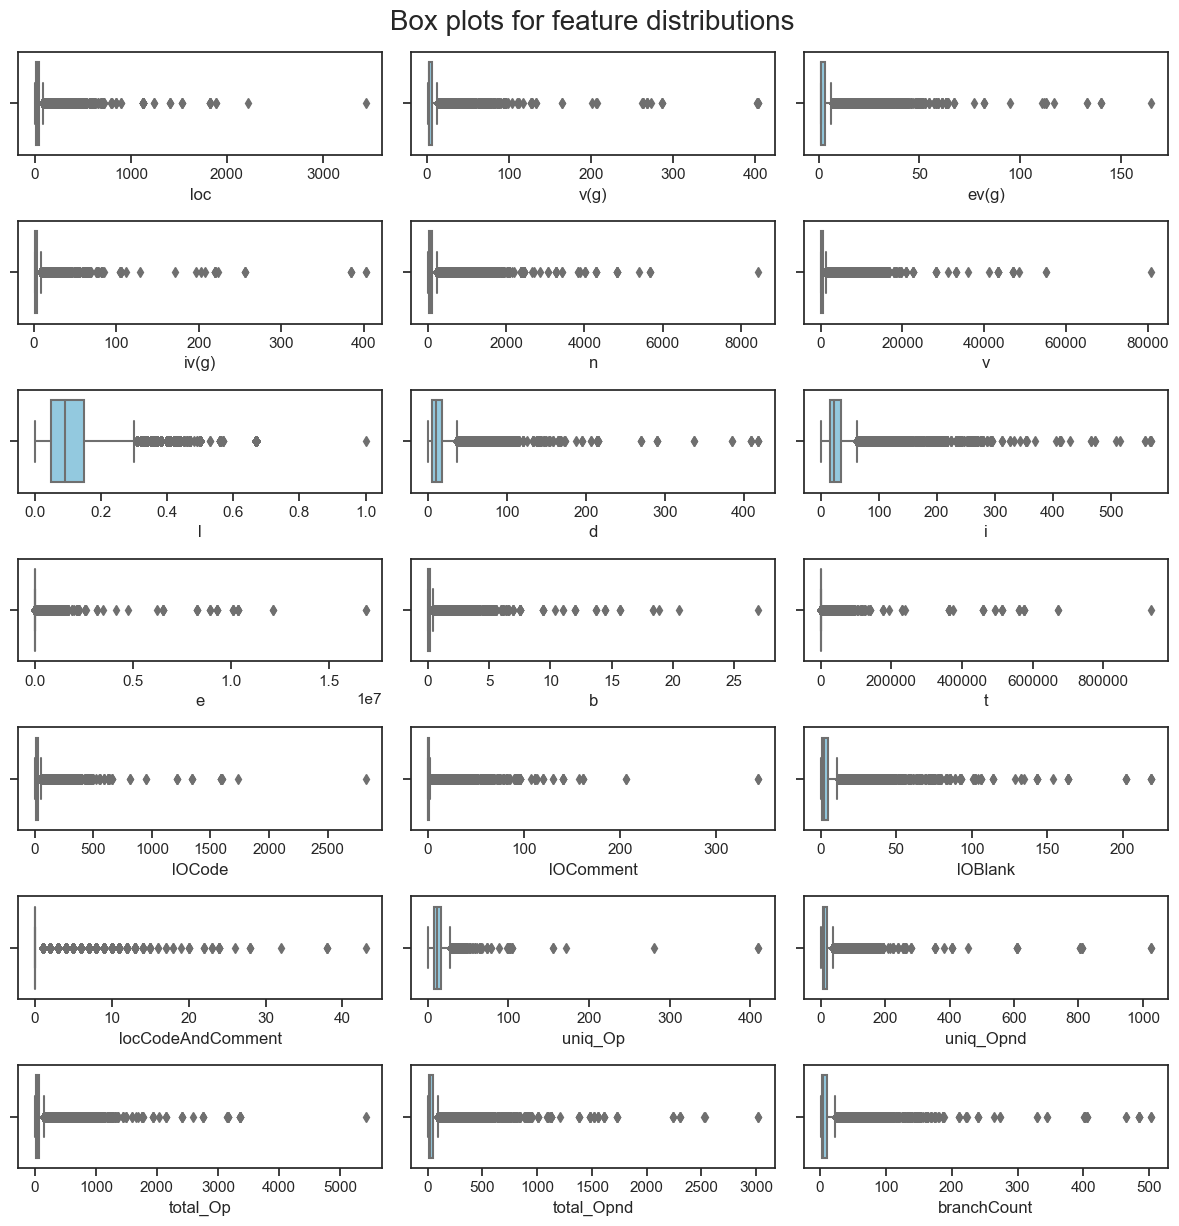

In [160]:
# 박스 플롯을 통해 이상치 확인

_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    sns.boxplot(x=train_df[col], ax=ax, color='skyblue')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Box plots for feature distributions', y=1.02, fontsize=20)
plt.show()

# 결과해석: 이상치가 존재 -> 이상치 제거 필요


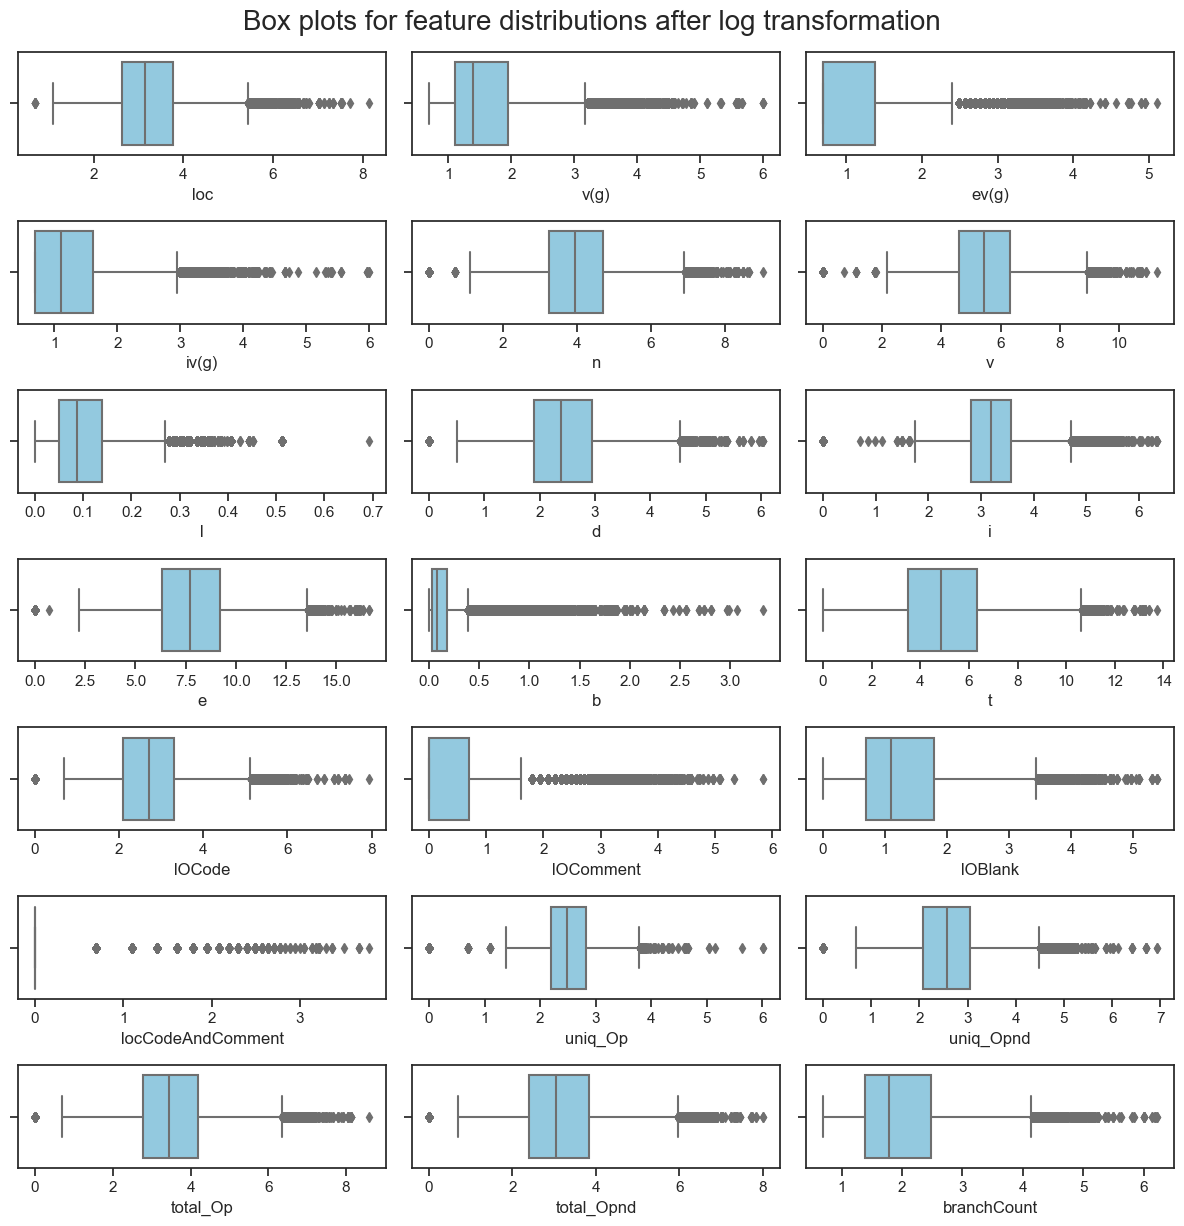

In [161]:
# (log transformation 적용된 데이터) 박스 플롯을 통해 이상치 확인

_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    sns.boxplot(x=np.log1p(train_df[col]), ax=ax, color='skyblue')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Box plots for feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

# 결과해석: log transformation을 통해 이상치가 줄어듦 -> 모델 성능 향상에 도움이 될 것으로 예상


In [162]:
# (log transformation 적용된 데이터) 박스 플롯을 통한 이상치 제거

# Tukey's fences를 사용하여 이상치 제거
def remove_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        df = df[(df[col] > fence_low) & (df[col] < fence_high)]
    return df

# 이상치 제거
columns = test_df.columns
train_df = remove_outliers(train_df, columns)


<Tukey's fences>
- 데이터의 사분위수를 기반으로 이상치를 판별하는 방법
- 데이터의 1사분위수와 3사분위수를 통해 IQR을 계산한 후, 이 IQR을 활용하여 특정한 경계값들을 설정 
- 이 경계값을 기준으로 이상치를 약한 이상치와 극단적인 이상치로 구분하여 판별


In [167]:
# Tukey's fences를 사용하여 이상치 제거 후 데이터 모양 확인

train_df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,


In [187]:
# target 분포 출력

df = pd.read_csv('train.csv')
freq_dist = df['defects'].value_counts()
percent_dist = freq_dist / len(df) * 100
print(percent_dist)


False    77.335574
True     22.664426
Name: defects, dtype: float64


<cross-validation>

<cross-validation>
- 교차 검증: StratifiedKFold: AUC(Area Under the ROC Curve) 계산 -> AUC 값이 1에 가까울수록 모델의 성능이 좋다고 판단, 0.5는 무작위 분류와 같은 성능을 나타냄

    Cross-validate the model with a StratifiedKFold

    The cross-validation score is printed and added to the global result_list
    :param model: 훈련 모델
    :param label: cross_val을 대표하는 이름
    :return: auc

<cross-validation>

In [195]:
# cross-validation 수행

result_list = []
def cross_val(model, label):
    start_time = datetime.now()
    k_fold = StratifiedKFold(shuffle=True, random_state=61)
    oof = np.full(len(train_df), np.nan)
    auc_list = []
    for fold_idx, (train_idx, val_idx) in enumerate(k_fold.split(train_df, train_df.defects)):
        X_train = train_df.iloc[train_idx]
        X_val = train_df.iloc[val_idx]
        y_train = X_train.pop('defects')
        y_val = X_val.pop('defects')
        model.fit(X_train, y_train)
        try:
            y_val_pred = model.predict_proba(X_val)[:, 1]
        except AttributeError:
            y_val_pred = model.decision_function(X_val)
        oof[val_idx] = y_val_pred
        auc = roc_auc_score(y_val, y_val_pred)
        auc_list.append(auc)
    auc = np.mean(auc_list)
    execution_time = datetime.now() - start_time
    print(f"{label}, # AUC {auc:.5f}, time={str(execution_time)[-15:-7]}")
    result_list.append((auc, label, execution_time))
    return auc

In [192]:
pop_df = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6], 'c':[7,8,9]})
print(pop_df.pop('b'))
print(pop_df)

# 결과해석: 5-fold cross-validation을 통해 모델 성능 평가 -> AUC가 높을수록 좋은 모델

0    4
1    5
2    6
Name: b, dtype: int64
   a  c
0  1  7
1  2  8
2  3  9


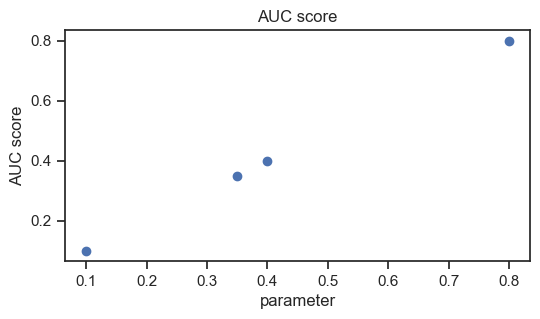

1.0


In [210]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def plot_score_list(score_list, label, parameter, xscale='linear'):
    """
    show a scatterplot of the scores in the global variable score_list
    :param label: 출력 이름
    :param score_list: score list
    :param parameter: 파라미터 이름
    :param xscale: 스케일 정보, linear or log
    :return: None
    """
    plt.figure(figsize=(6,3))
    plt.scatter([p for p, _ in score_list], [s for _, s in score_list])
    plt.xscale(xscale)
    plt.xlabel(f"{parameter}{' (log-scale)' if xscale=='log' else ''}")
    plt.ylabel('AUC score')
    plt.title(label)
    plt.show()

y_true = [0, 1, 0, 1]
y_scores = [0.1, 0.4, 0.35, 0.8]

# AUC Score 출력
plot_score_list(list(zip(y_scores, y_scores)), 'AUC score', 'parameter', 'linear')

# AUC Score 계산
auc_score = roc_auc_score(y_true, y_scores)
print(auc_score)

# 결과해석: AUC score가 높을수록 좋은 모델


<cross-validaton>